# Setup the environment

The following cell is designated to import all required python packages. The next one allows us to easily install new packages, and it makes sure that the new package is added to the proper python env. 


In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

#sklearn imports 
from sklearn.model_selection  import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

# xgboost 
import xgboost as xgb
from xgboost import plot_importance

from tqdm.notebook import tqdm


In [21]:
# execute this cell to install a new package 
import sys
!{sys.executable} -m pip install --upgrade xgboost

     |████████████████████████████████| 109.8MB 59.8MB/s eta 0:00:01


In [30]:
# execute this cell to check memory
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('target_info', 154354592),
 ('GridSearchCV', 1056),
 ('RandomizedSearchCV', 1056),
 ('auc', 136),
 ('classification_report', 136),
 ('confusion_matrix', 136),
 ('plot_importance', 136),
 ('roc_auc_score', 136),
 ('roc_curve', 136),
 ('train_test_split', 136),
 ('gridspec', 80),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('sns', 80),
 ('sp', 80),
 ('xgb', 80)]


del particle_info_df

In [2]:
data = pd.read_csv("/data/work/wessex/Wessex/test/Brunel_track_seeds_with_target.csv")

In [3]:
data.head()

,Unnamed: 0,Unnamed: 0_x,eventID,track_phi,track_tx,track_ty,track_nLHCbIDs,particle_key,track_p,track_chi2,...,track_pseudoRapidity,track_position_r,track_position_phi,Unnamed: 0_y,particle_hasUT,particle_pid,particle_hasScifi,particle_isDown_noVelo,particle_isDown,particle_hasVelo
0,0,0,31123,2.849378,-0.343474,0.103326,12.0,997,2020.072174,6.275086,...,1.749189,7599.958646,1.156534,977,True,-211,True,False,True,True
1,1,1,31123,-3.082239,-0.358948,-0.021330,12.0,1061,3841.771978,1.360128,...,1.746825,7578.755154,-3.011232,1041,True,-211,True,False,True,True
2,2,2,31123,-0.011027,0.096606,-0.001065,11.0,1066,11831.335600,1.228229,...,3.032522,7503.689479,-0.021707,1046,False,2212,True,False,False,False
3,3,3,31123,3.105371,-0.442834,0.016047,9.0,1105,1982.935289,1.397992,...,1.552877,7505.289515,2.717953,1085,False,-211,True,False,False,False
4,4,4,31123,-3.125277,-0.170356,-0.002780,11.0,1184,6950.099982,1.731246,...,2.470060,7512.987296,-3.044312,1164,False,-211,True,False,False,False


In [5]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0_x', 'eventID', 'track_phi', 'track_tx',
       'track_ty', 'track_nLHCbIDs', 'particle_key', 'track_p', 'track_chi2',
       'track_charge', 'track_position_x', 'track_position_y',
       'track_position_z', 'track_chi2PerDoF', 'track_pt',
       'track_pseudoRapidity', 'track_position_r', 'track_position_phi',
       'Unnamed: 0_y', 'particle_hasUT', 'particle_pid', 'particle_hasScifi',
       'particle_isDown_noVelo', 'particle_isDown', 'particle_hasVelo'],
      dtype='object')

In [26]:
data.particle_pid.unique() # no electrons in DS, no need to remove them

array([      -211,       2212,        211,        -11,         11,
             -321,        -13,      -2212,        321,         13,
       1000010020, 1000010030,       3112,       3312,      -3112,
             3222,      -3312,      -3222, 1000020030])

In [40]:
target = data.particle_isDown_noVelo 
features = data.drop(["Unnamed: 0", 
                      "Unnamed: 0_x", # index
                      "Unnamed: 0_y",
                      "eventID",
                      "particle_key",
                      "particle_hasUT",
                      "particle_pid", # this are MC info
                      "particle_hasScifi",
                      "particle_isDown_noVelo",
                      "particle_isDown",
                      "particle_hasVelo",
                      "track_charge",
                      "track_position_z",
                     ], axis=1)

In [41]:
features.describe()


,track_phi,track_tx,track_ty,track_nLHCbIDs,track_p,track_chi2,track_position_x,track_position_y,track_chi2PerDoF,track_pt,track_pseudoRapidity,track_position_r,track_position_phi
count,6.431437e+06,6.431437e+06,6.431437e+06,6.431437e+06,6.431437e+06,6.431437e+06,6.431437e+06,6.431437e+06,6.431437e+06,6.431437e+06,6.431437e+06,6.431437e+06,6.431437e+06
mean,-9.180059e-03,9.766331e-03,-2.026875e-05,1.149569e+01,1.420809e+04,3.711409e+00,1.305604e+01,1.565849e-01,5.778934e-01,1.396152e+03,2.496262e+00,7.551233e+03,-2.820630e-03
std,2.027747e+00,2.916683e-01,6.022695e-02,7.036186e-01,1.577163e+06,3.146907e+00,7.482142e+02,4.640469e+02,5.002525e-01,4.711238e+04,8.669457e-01,6.487191e+01,1.910327e+00
min,-3.141593e+00,-1.065129e+00,-3.574735e-01,9.000000e+00,1.159092e+03,4.607473e-03,-2.685365e+03,-2.045761e+03,9.576724e-04,1.810341e+00,8.051839e-01,7.500001e+03,-3.141592e+00
25%,-1.330413e+00,-1.611965e-01,-2.717713e-02,1.100000e+01,3.564293e+03,1.521741e+00,-4.312120e+02,-1.983331e+02,2.342322e-01,1.029603e+03,1.792865e+00,7.506400e+03,-1.522130e+00
50%,-3.502527e-04,1.184711e-02,-3.666391e-05,1.200000e+01,6.622924e+03,2.749151e+00,1.878130e+01,3.957736e-02,4.226088e-01,1.180632e+03,2.404673e+00,7.523652e+03,1.467536e-04
75%,1.184641e+00,1.815467e-01,2.716001e-02,1.200000e+01,1.383892e+04,4.902061e+00,4.630185e+02,1.986999e+02,7.582973e-01,1.435225e+03,3.106766e+00,7.572400e+03,1.505417e+00
max,3.141593e+00,1.097104e+00,3.441273e-01,1.200000e+01,3.918442e+09,3.741587e+01,2.693798e+03,2.053188e+03,6.235979e+00,1.086715e+08,1.015745e+01,8.147208e+03,3.141590e+00


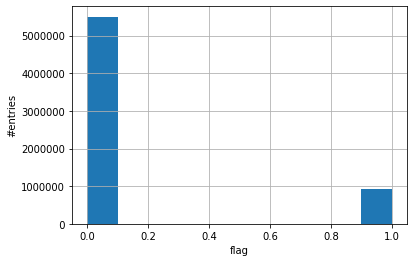

In [61]:
from matplotlib.ticker import FormatStrFormatter

ax = target.astype(float).hist();
ax.set_xlabel("flag");
ax.set_ylabel("#entries");
ax.yaxis.set_major_formatter(FormatStrFormatter('%3d'))

In [80]:
def print_features_histograms(features, target):
    hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
    # create the figure
    fig = plt.figure(figsize=(16,  25))
    for n, feature in enumerate(features):
        # add sub plot on our figure
        n_figs = features.shape[1] 
        if n_figs % 2 == 1:
            n_figs+=1
        ax = fig.add_subplot(n_figs // 2, 2, n + 1)
        # define range for histograms by cutting 1% of data from both ends
        min_value, max_value = np.percentile(features[feature], [1, 99])
        min_value-=0.1*max_value
        max_value+=0.2*max_value
        ax.hist(features.ix[target == 0, feature].values, range=(min_value, max_value), 
                 label='ghost', **hist_params)
        ax.hist(features.ix[target == 1, feature].values, range=(min_value, max_value), 
                 label='true', **hist_params)
        ax.legend(loc='best')

        ax.set_title(feature)


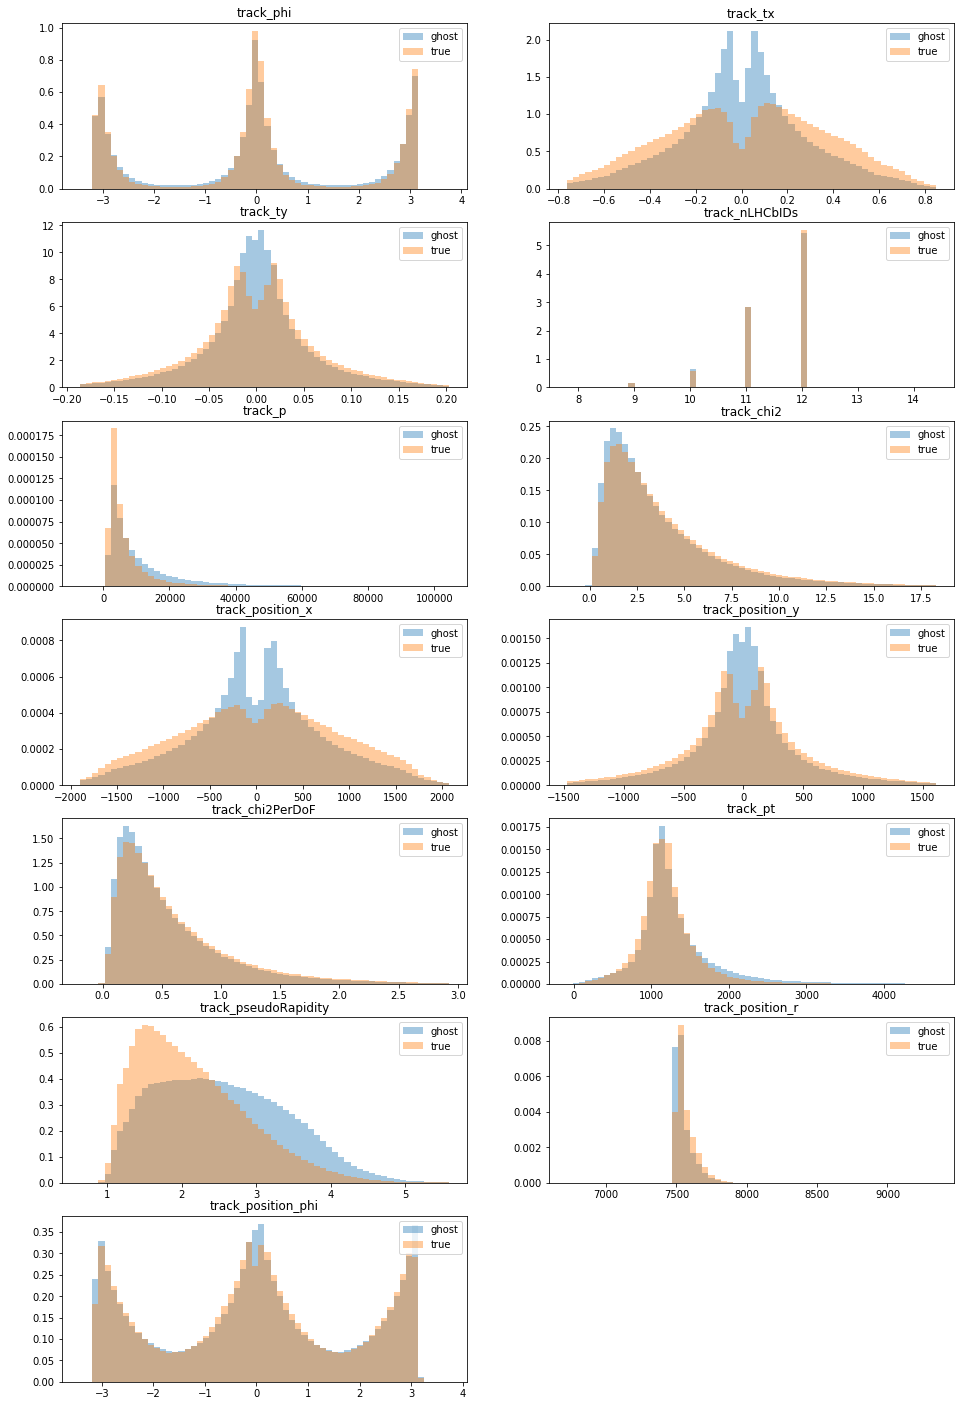

In [81]:
print_features_histograms(features, target)


In [92]:
df = pd.concat([features,target])

In [93]:
df.head()

,track_phi,track_tx,track_ty,track_nLHCbIDs,track_p,track_chi2,track_position_x,track_position_y,track_chi2PerDoF,track_pt,track_pseudoRapidity,track_position_r,track_position_phi,0
0,2.849378,-0.343474,0.103326,12.0,2020.072174,6.275086,494.515198,1124.644897,0.896441,682.012956,1.749189,7599.958646,1.156534,NaN
1,-3.082239,-0.358948,-0.021330,12.0,3841.771978,1.360128,-1080.491943,-141.657471,0.194304,1299.941130,1.746825,7578.755154,-3.011232,NaN
2,-0.011027,0.096606,-0.001065,11.0,11831.335600,1.228229,235.222702,-5.106698,0.204705,1137.754221,3.032522,7503.689479,-0.021707,NaN
3,3.105371,-0.442834,0.016047,9.0,1982.935289,1.397992,-256.822998,115.813004,0.349498,803.347165,1.552877,7505.289515,2.717953,NaN
4,-3.125277,-0.170356,-0.002780,11.0,6950.099982,1.731246,-439.475525,-42.887833,0.288541,1167.325690,2.470060,7512.987296,-3.044312,NaN


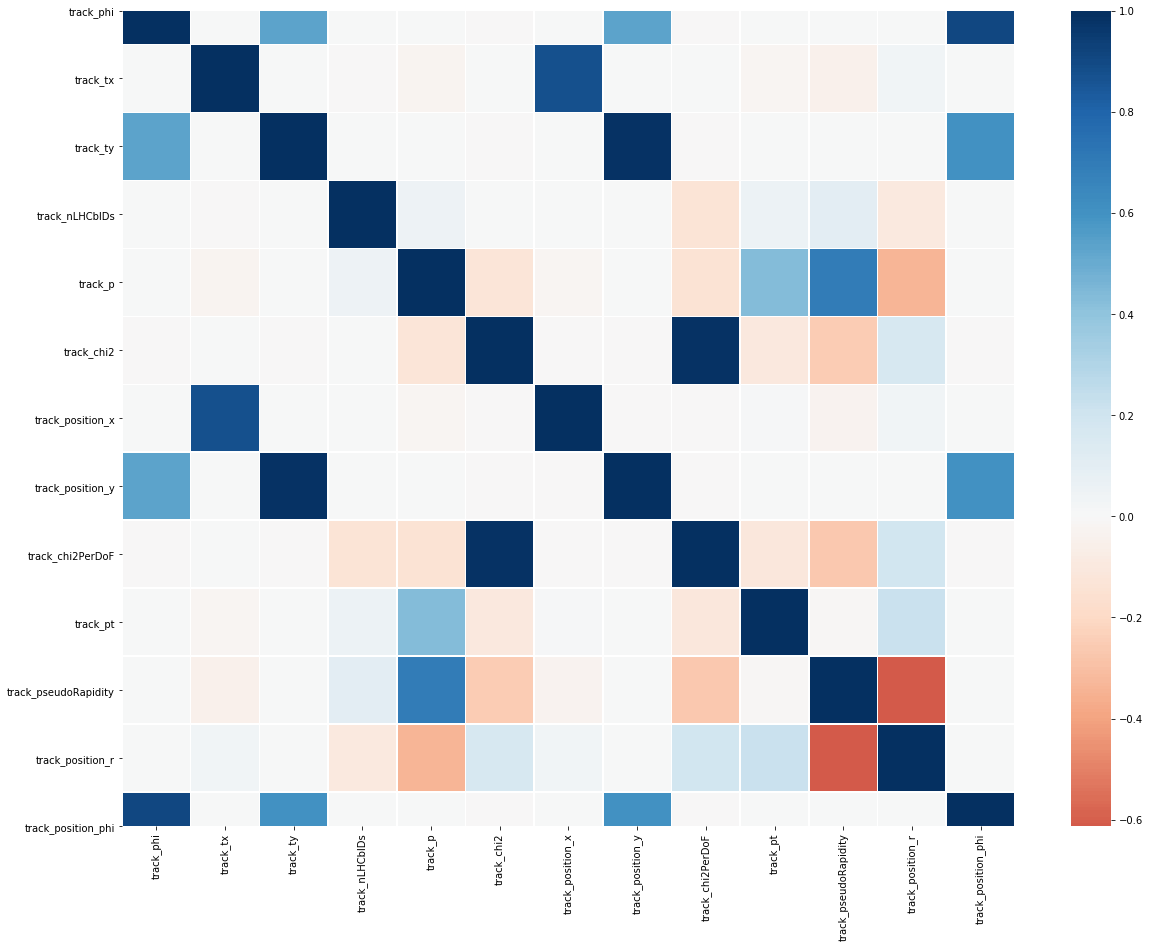

In [106]:
cor_mat = features[target==True].corr()
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(cor_mat,linewidths=.5, ax=ax, center=0,cmap="RdBu");


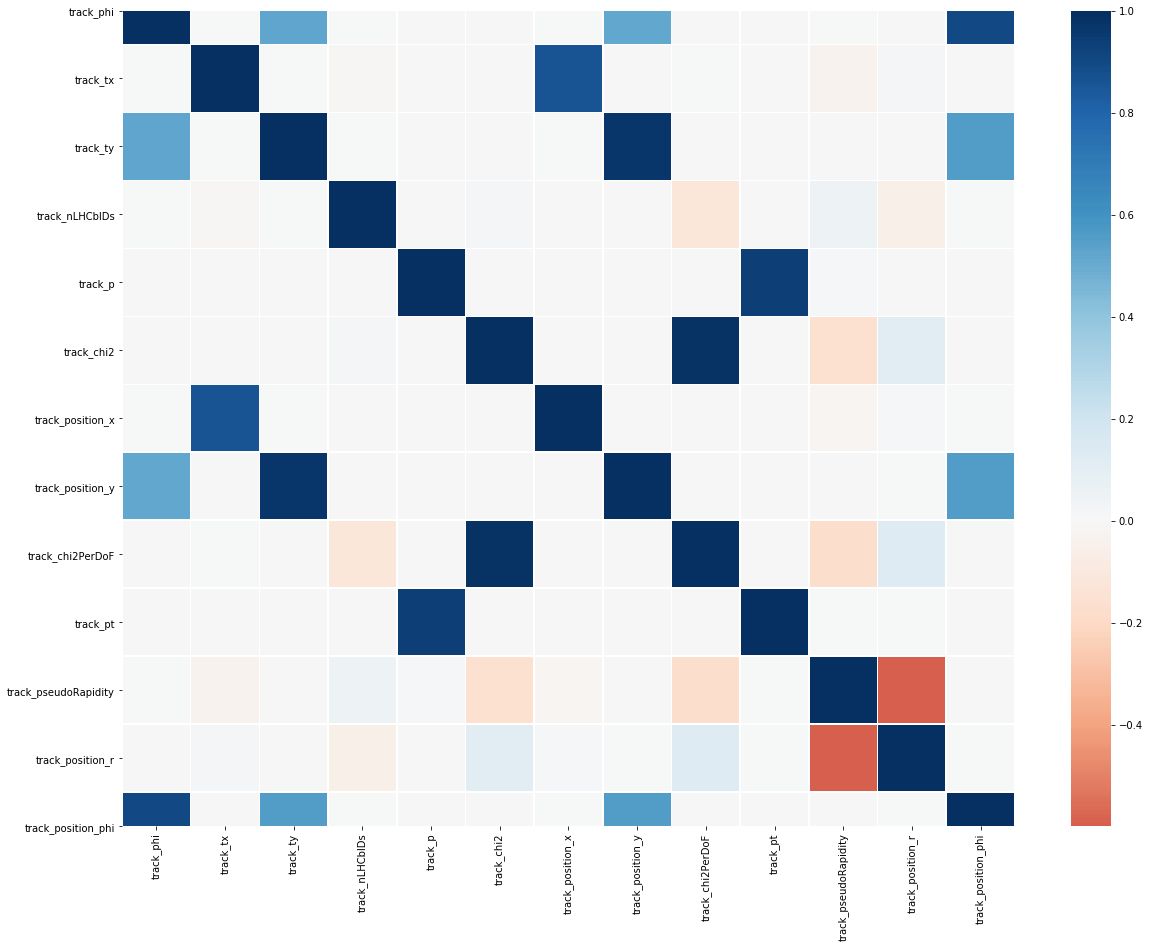

In [105]:
cor_mat = features[target==False].corr()
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(cor_mat,linewidths=.5, ax=ax, center=0, cmap="RdBu");


## Play with FT_hits
Try to reduce its size by removing the hits that are not associated to any of tracks. 
I assume there a lot of hits that are not needed. The hits will be used to as an input to RNN or transformer.


In [14]:
target_info = data[["eventID","particle_key","particle_isDown_noVelo"]]
target_info = target_info.astype(int)
target_info.head()

,eventID,particle_key,particle_isDown_noVelo
0,31123,997,0
1,31123,1061,0
2,31123,1066,0
3,31123,1105,0
4,31123,1184,0


In [17]:
chunksize = 1000000

In [ ]:
n_chanks = 260314507//chunksize+1
for df_chunk in tqdm(pd.read_csv("/data/work/wessex/Wessex/test/FT_Hits.csv", 
                                chunksize=chunksize), leave=False, total=n_chanks):
    df_chunk.eventID = df_chunk.eventID.astype(int)
    df_chunk.particle_key = df_chunk.FT_particle_key.astype(int)
    merged = df_chunk.merge(target_info,
                   left_on=["eventID","FT_particle_key"], 
                   right_on=["eventID","particle_key"],
                   how="inner", validate="m:1")
    with open("/data/work/wessex/Wessex/test/FT_hits_with_info.csv", 'a') as f:    
        merged.to_csv(f, header=f.tell()==0, mode="a")